In [4]:
import numpy as np
import pandas as pd 

df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")  # for final submission

x_train = df_train.copy()
x_train.drop('id', axis=1, inplace=True)
x_train.drop('Product ID', axis=1, inplace=True)
x_train.drop('Machine failure', axis=1, inplace=True)
y_train = df_train["Machine failure"]

x_test = df_test.copy()
x_test.drop('id', axis=1, inplace=True)
x_test.drop('Product ID', axis=1, inplace=True)

x_train = np.array(x_train)
y_train = np.array(y_train, dtype=np.float32)
x_test = np.array(x_test)

lm_column = 0
x_train[:, lm_column] = np.where(x_train[:, lm_column] == 'L', 0, 1)
x_test[:, lm_column] = np.where(x_test[:, lm_column] == 'L', 0, 1)

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

print(x_train[:5, :])

[[0.000e+00 3.006e+02 3.096e+02 1.596e+03 3.610e+01 1.400e+02 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [1.000e+00 3.026e+02 3.121e+02 1.759e+03 2.910e+01 2.000e+02 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 2.993e+02 3.085e+02 1.805e+03 2.650e+01 2.500e+01 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 3.010e+02 3.109e+02 1.524e+03 4.430e+01 1.970e+02 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [1.000e+00 2.980e+02 3.090e+02 1.641e+03 3.540e+01 3.400e+01 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00]]


In [5]:
from sklearn.model_selection import train_test_split

x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [6]:
def estimate_gaussian(X):
    m, n = X.shape

    mu = 1/m * np.sum(X, axis=0)
    var = 1/m * np.sum((X - mu)**2, axis=0)
        
    return mu, var

In [7]:
def multivariate_gaussian(X, mu, var):    
    k = len(mu)
    
    if var.ndim == 1:
        var = np.diag(var)
        
    X = X - mu
    p = (2* np.pi)**(-k/2) * np.linalg.det(var)**(-0.5) * \
        np.exp(-0.5 * np.sum(np.matmul(X, np.linalg.pinv(var)) * X, axis=1))
    
    return p

In [12]:
def select_threshold(y_val, p_val): 
    best_epsilon = 0
    best_F1 = 0
    F1 = 0
    
    step_size = (max(p_val) - min(p_val)) / 1000
    
    for epsilon in np.arange(min(p_val), max(p_val), step_size):
        predictions = (p_val < epsilon).astype(int)  # Predictions for each example using epsilon as threshold

        tp = np.sum((predictions == 1) & (y_val == 1))  # Number of true positives
        fp = np.sum((predictions == 1) & (y_val == 0))  # Number of false positives
        fn = np.sum((predictions == 0) & (y_val == 1))  # Number of false negatives

        if tp + fp == 0:
            prec = 0  # Set precision to 0 when both tp and fp are zero
        else:
            prec = tp / (tp + fp)  # Precision
            
        rec = tp / (tp + fn)  # Recall

        if prec + rec == 0:
            F1 = 0  # Set F1 score to 0 when both prec and rec are zero
        else:
            F1 = 2 * prec * rec / (prec + rec)  # F1 score
        
        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon
        
    return best_epsilon, best_F1

In [14]:
mu, var = estimate_gaussian(x_train)

# Evaluate the probabilites for the training set
p = multivariate_gaussian(x_train, mu, var)

# Evaluate the probabilites for the cross validation set
p_val = multivariate_gaussian(x_cv, mu, var)

# Find the best threshold
epsilon, F1 = select_threshold(y_cv, p_val)

print('Best epsilon found using cross-validation: %e'% epsilon)
print('Best F1 on Cross Validation Set:  %f'% F1)
print('# Anomalies found: %d'% sum(p < epsilon))

Best epsilon found using cross-validation: 9.045873e-07
Best F1 on Cross Validation Set:  0.386079
# Anomalies found: 5557


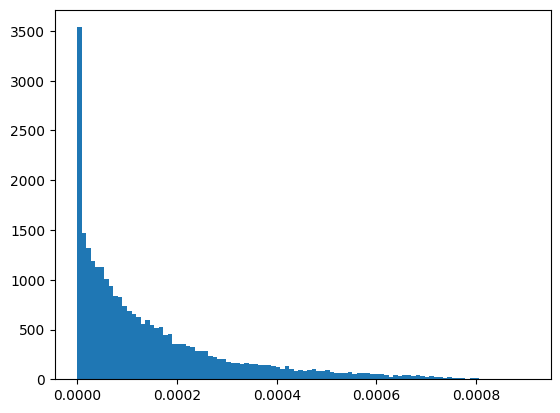

In [19]:
import matplotlib.pyplot as plt 

plt.hist(p_val, bins=100)
plt.show()